In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
import json
import pickle
import osmnx as ox
import networkx as nx

In [2]:
import trips

In [2]:
df=pd.read_csv('../DC/core_poi-patterns')

## Tasks:

1) locate only lat/long of places inside DC area (currently is a much greater distance)

2) find trips entering this area as well as leaving this area 

3) from trips get ODs corresponding to shortest time paths


In [3]:
#Task 1

In [5]:
#reading in census files in order to get cbg lat longs (the origin lat longs are not given from SafeGraph-only cbg IDs.)
df_census=pd.read_csv('../safegraph_open_census_data_2019/data/cbg_b01.csv')
df_geog=pd.read_csv('../safegraph_open_census_data_2019/metadata/cbg_geographic_data.csv')

In [6]:
df_census=df_geog.merge(df_census, how='inner', on='census_block_group')
df_census=df_census[['census_block_group', 'amount_land', 'amount_water', 'latitude',
       'longitude','B01003e1']]

In [8]:
df2=df.dropna(subset=['visitor_home_cbgs']).reset_index(drop=True)
df3=df2.copy()

In [ ]:
#now getting all the ODs by looping through safegraph poi data; each point in that df2 is a unique destination, and 
#has info on corresponding origins

OD_dict=defaultdict(int)
c=0
for i in range(0,len(df3)):
    O_dict=json.loads(df2['visitor_home_cbgs'][i]) # visitor origins
    

    for O,V in O_dict.items():
        try:
            np.int64(O)
           
            OD_dict[(O,df3['latitude'][df3.index[i]],df3['longitude'][df3.index[i]])]+=V
        except:
            c+=1
            

            
        
    print(i)
        

In [10]:
len(OD_dict)

1265891

In [11]:
df_OD = pd.DataFrame(list(OD_dict.items()), columns=['OD','trips'])
df_OD[['O', 'lat_D','long_D']] = pd.DataFrame(df_OD['OD'].tolist(), index=df_OD.index)
#df_OD contains lat and longs of Destinations, origin CBGs, as well as number of trips from specific origins to destinations

In [12]:
df_OD['O']=df_OD['O'].astype(np.int64)
df_OD_ll=pd.merge(df_OD,df_census[['census_block_group','latitude','longitude']],how='inner',left_on='O',right_on='census_block_group')
df_OD_ll=df_OD_ll[['O','latitude','longitude','lat_D','long_D','trips']]
df_OD_ll.columns=['O','lat_O','long_O','lat_D','long_D','trips']

#finally getting origin and destination lat longs by merging with census data, as well as number of trips!

In [3]:
place_name="Washington DC, USA"
G = ox.graph_from_place(place_name,network_type='drive', simplify=True)

In [15]:
#getting nearest nodes on osmnx graph from origin and destinations

ox_id_O,dist_ox_O=ox.distance.nearest_nodes(G, df_OD_ll['long_O'],df_OD_ll['lat_O'], return_dist=True)
ox_id_D,dist_ox_D=ox.distance.nearest_nodes(G, df_OD_ll['long_D'],df_OD_ll['lat_D'], return_dist=True)

In [19]:
df_OD_ll['dist_D']=dist_ox_D
df_OD_ll['dist_O']=dist_ox_O

df_OD_ll['osm_D']=ox_id_D
df_OD_ll['osm_O']=ox_id_O

In [20]:
#making the data restricted to within 10 km from OSMnx nodes

df_OD_ll_c=df_OD_ll.loc[(df_OD_ll['dist_D']<=10000) & (df_OD_ll['dist_O']<=10000)]

In [21]:
#so that one of the destinations/origins is for sure inside the DC street network
df_OD_ll_c2=df_OD_ll_c.loc[(df_OD_ll_c['dist_D']<=1000) | (df_OD_ll_c['dist_O']<=1000)].reset_index(drop=True)

In [22]:
df_OD_ll_c2.to_csv('df_OD_ll_c2.csv')

In [22]:
df_OD_ll_c2=pd.read_csv('df_OD_ll_c2.csv')
len(df_OD_ll_c2)

110541

In [23]:
df_OD_ll_c2.head()

,O,lat_O,long_O,lat_D,long_D,trips,dist_D,dist_O,osm_D,osm_O
0,240338035193,38.897303,-76.858576,38.872970,-77.006965,4,93.106359,4532.209238,49759499,1231873643
1,240338035193,38.897303,-76.858576,38.937902,-76.992490,4,83.152595,4532.209238,49757435,1231873643
2,240338035193,38.897303,-76.858576,38.919409,-76.992536,4,107.059074,4532.209238,49858149,1231873643
3,240338035193,38.897303,-76.858576,38.929460,-76.974860,4,22.838358,4532.209238,49744963,1231873643
4,240338035193,38.897303,-76.858576,38.901157,-76.995284,4,33.680722,4532.209238,49790030,1231873643


In [24]:
OD_in=df_OD_ll_c2[['osm_O','osm_D']].copy()
OD_in.columns=['ID_osm_start','ID_osm_end']
OD_in['trips']=df_OD_ll_c2['trips']

In [25]:
OD_in.to_csv('OD_in.csv')

In [ ]:
#processing

In [4]:
OD_in=pd.read_csv('OD_in.csv')

In [ ]:
trips.trips_OD(G,OD_in,'')

In [5]:
routes_raw=pickle.load( open( "routes_raw_tt_io.data", "rb" ) )

In [6]:
routes=np.loadtxt('routes_tt_io2.txt')

In [ ]:
trips.tar(routes,routes_raw,'')

In [7]:
routes_imp=routes[np.argsort(-1*routes[:,1])]

In [10]:
trips2=np.loadtxt('trips_tt_io2.txt')

In [ ]:
trips.removal_perc(routes_imp,routes_raw,trips2,'_t')

In [13]:
c_t=np.loadtxt('c_sum_trips_frac_t.txt')

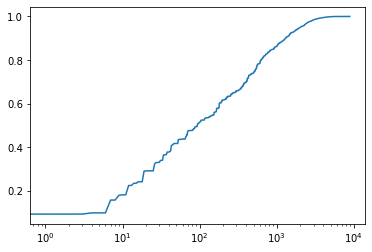

In [14]:
plt.semilogx(c_t)

In [8]:
#iterative removal

tar=np.loadtxt('tar')

routes_it=np.zeros([len(tar),2])
routes_it[:,0]=tar

#random removal

routes_ran=routes.copy()
np.random.shuffle(routes_ran)



In [ ]:
trips.removal_perc(routes_it,routes_raw,trips2,'_it')
trips.removal_perc(routes_ran,routes_raw,trips2,'_r')


In [11]:
def perc(nodes_dis,G,OD_in,name):

#nodes_dis=routes[np.argsort(-1*routes[:,1]),0]
#nodes_dis_r=nodes_dis.copy()
    p=np.zeros(len(nodes_dis))
    G2=G.copy()
    for i in range(0, len(nodes_dis)):
        G2=G.copy()
        #random.shuffle(nodes_dis_r)
        G2.remove_nodes_from(list(nodes_dis[0:i]))
        OD_in_s=OD_in.sample(n=1000,weights=OD_in['trips'])
        OD_in_s=OD_in_s.reset_index(drop=True)
        OD_in_s.columns
        for j in range(0, len(OD_in_s)):
            if(G2.has_node(OD_in_s['ID_osm_start'][j]) & G2.has_node(OD_in_s['ID_osm_end'][j])):
                #is there still a path after removing nodes?
                p[i]+=nx.has_path(G2,OD_in_s['ID_osm_start'][j],OD_in_s['ID_osm_end'][j])*1
        print(i,p[i])
    np.savetxt('p_tt_sub1000'+name+'.txt',p)


In [ ]:
trips.perc(routes_imp[:,0],G,OD_in,'_t')
trips.perc(routes_it[:,0],G,OD_in,'_it')
trips.perc(routes_ran[:,0],G,OD_in,'_r')